## Imports

In [44]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv2D, RepeatVector, TimeDistributed, BatchNormalization

In [2]:
from timeseries import evaluate, preproc

In [3]:
%matplotlib inline

## Functions

## Data Ingestion

In [4]:
dataset = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset = dataset.replace('?', np.nan).astype('float32').fillna(method='ffill')

## Data Preparation

In [5]:
meter_cols = [x for x in dataset.columns if 'Sub' in x]
dataset['Sub_metering_4'] = dataset['Global_active_power']*1000/60 - dataset[meter_cols].sum(axis=1)
dataset = dataset.resample('D').sum()

In [6]:
dataset.head(20)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781
2006-12-21,1717.112061,144.166000,347100.87500,7240.600098,1765.0,2623.0,10421.0,13809.533203
2006-12-22,2341.337891,186.906006,347305.75000,9897.000000,3151.0,350.0,11131.0,24390.300781
2006-12-23,4773.386230,221.470001,345795.93750,20200.400391,2669.0,425.0,14726.0,61736.433594
2006-12-24,2550.011963,149.899994,348029.90625,11002.200195,1703.0,5082.0,6891.0,28824.199219


## Model

### Config

In [102]:
n_input = 7*8
n_output = 7

### Data

In [103]:
# Train and holdout
train = dataset.iloc[1:-328,:].values
holdout = dataset.iloc[-328:-6,:].values

In [104]:
# Trim train data to be equal weeks
train_trim = len(train) % n_input
if train_trim > 0:
    train = train[:-train_trim]

In [117]:
# Get X and y trains
X_train, y_train = preproc.to_supervised(train[:,0], n_input, n_output, False)
X_train = X_train.reshape(-1, n_input, 1)
y_train = y_train.reshape(-1, n_output)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])

In [118]:
X_train.shape

(1001, 56, 1)

In [119]:
def build_model(n_timesteps, n_features, n_outputs):
    
    # Define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

In [120]:
# mdl = build_model(X_train.shape[1], X_train.shape[2], y_train.shape[1])
mdl = build_model(n_input, 1, n_output)

In [121]:
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_33 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_34 (Dense)             (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________


In [122]:
history = mdl.fit(X_train, y_train,
                   epochs=20,
                   batch_size=100,
                   verbose=1)

Epoch 1/20
1001/1001 [==============================] - 2s 2ms/step - loss: 2454583.1523 - mean_absolute_error: 1332.1018
Epoch 2/20
1001/1001 [==============================] - 0s 416us/step - loss: 1858790.2771 - mean_absolute_error: 980.9735
Epoch 3/20
1001/1001 [==============================] - 0s 413us/step - loss: 1645094.7370 - mean_absolute_error: 910.8341
Epoch 4/20
1001/1001 [==============================] - 0s 411us/step - loss: 1203875.8162 - mean_absolute_error: 826.2192
Epoch 5/20
1001/1001 [==============================] - 0s 409us/step - loss: 908329.7263 - mean_absolute_error: 730.9376
Epoch 6/20
1001/1001 [==============================] - 0s 416us/step - loss: 1078855.7508 - mean_absolute_error: 753.0006
Epoch 7/20
1001/1001 [==============================] - 0s 418us/step - loss: 1246256.2207 - mean_absolute_error: 808.8848
Epoch 8/20
1001/1001 [==============================] - 0s 421us/step - loss: 1209244.5775 - mean_absolute_error: 844.6122
Epoch 9/20
1001/10

In [123]:
resids = evaluate.resids(mdl, X_train, y_train, n_input, n_output)
resids_df = pd.DataFrame(resids, columns=['su','m','tu','w','th','f','sa'])

Residual Hist


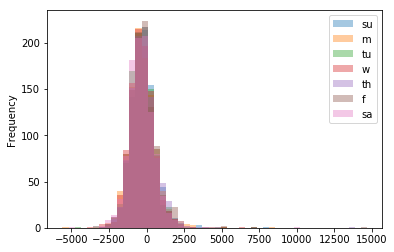

In [124]:
print('Residual Hist')
resids_df.plot(kind='hist', bins=50, alpha=0.4)

RMS by day


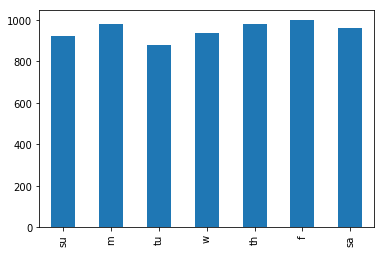

In [125]:
print('RMS by day')
resids_df.applymap(np.square).mean().apply(np.sqrt).plot(kind='bar')

MAE by day


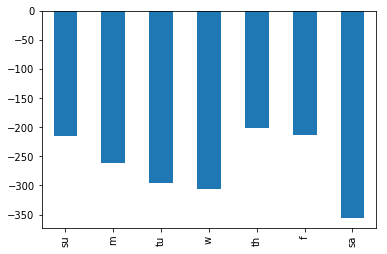

In [126]:
print('MAE by day')
resids_df.mean().plot(kind='bar')